In [1]:
%load_ext autoreload
%autoreload 2
import os
#change current working directory to the parent directory
if 'changed' not in globals():
    os.chdir("..")
    os.chdir("..")
    global changed
    changed = True
import numpy as np
import sr_mcmc as srmc
import argparse
import config_lib as cl
import deathTimesDataSet as dtds
import ast
import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
import SRmodellib as sr
import SRmodellib_lifelines as srl
import emcee
import SR_hetro as srh

In [2]:
config_paths ={
    'Denmark_M_1890':"configs/HUMANS/configs_Denmark_M_1890",
    'Denmark_M_1900':"configs/HUMANS/configs_Denmark_M_1900",
    'Sweden_M_1910':"configs/HUMANS/configs_Sweden_M_1910_hetro",
}
thresholds = {
    'Denmark_M_1890':92,
    'Denmark_M_1900':92,
    'Sweden_M_1910':70,
}
apply_thresh = True
scale =365
#get the name of current folder:
current_folder = os.path.basename(os.getcwd())
results_path = 'results_csvs/humans_M_combined.csv'
data_key = 'Sweden_M_1910'


In [3]:
configs = {}
for key in config_paths.keys():
    configs[key] = cl.read_configs(config_paths[key])

submission_folders={}
h5_paths = {}
data_files ={}
for key in configs.keys():
    index = int(configs[key].get('DEFAULT', 'index'))
    submission_folder = configs[key].get(f'SUBMISSION_{index-1}', 'submission_folder')
    submission_folder = submission_folder.split(current_folder)[-1]
    submission_folder = submission_folder[1:]
    submission_folders[key] = submission_folder
    data_file = configs[key].get('DEFAULT', 'data_file')
    data_file = data_file.split(current_folder)[-1]
    data_file = data_file[1:]
    data_files[key] = data_file
    h5_paths[key] = os.path.join(submission_folders[key],'h5_files') 



ds = dtds.dsFromFile(data_files[data_key])


In [4]:
samples_trans0 = {}
lnprobs0 = {}
for key in configs.keys():
    samples_trans0[key], lnprobs0[key] = srmc.loadSamplesFromDir(h5_paths[key], best=False, thin =5, discard=200)

In [5]:
for key in samples_trans0.keys():
    print(key)
    print(samples_trans0[key].shape)

Denmark_M_1890
(4999480, 5)
Denmark_M_1900
(4997200, 5)
Sweden_M_1910
(3994360, 5)


In [6]:
samples_trans = {}
lnprobs = {}
if apply_thresh:
    for key in configs.keys():
        thresh = np.percentile(lnprobs0[key],thresholds[key] )
        samples_trans[key] = samples_trans0[key][lnprobs0[key]>thresh]
        lnprobs[key] = lnprobs0[key][lnprobs0[key]>thresh]

for key in samples_trans.keys():
    samples_trans[key] = samples_trans[key][np.argsort(lnprobs[key])]
    lnprobs[key] = lnprobs[key][np.argsort(lnprobs[key])]

In [7]:
for key in samples_trans.keys():
    print(key)
    print(samples_trans[key].shape)

Denmark_M_1890
(399939, 5)
Denmark_M_1900
(399650, 5)
Sweden_M_1910
(1198282, 5)


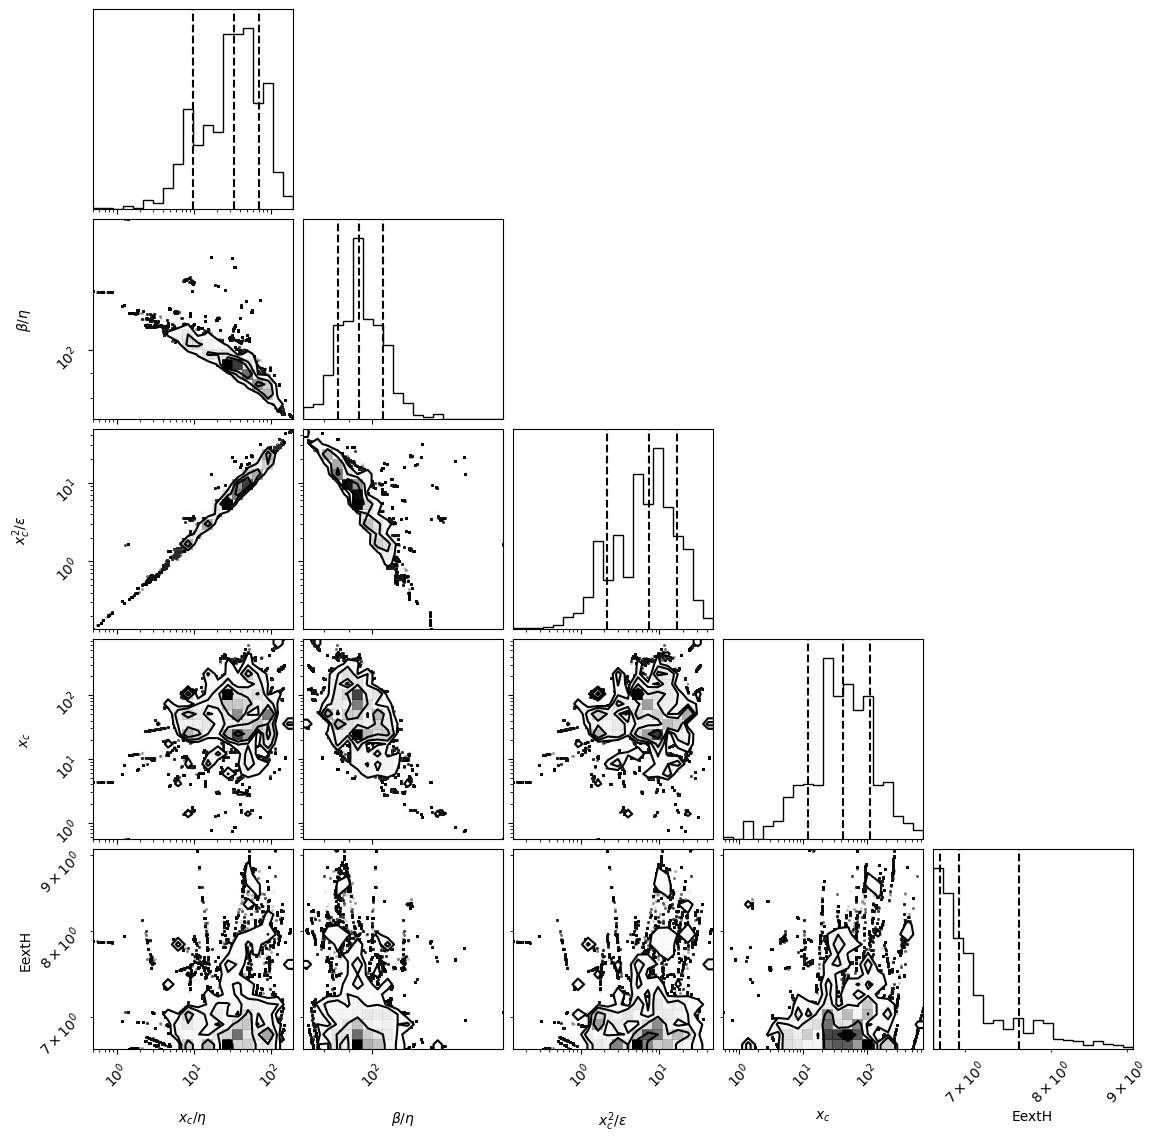

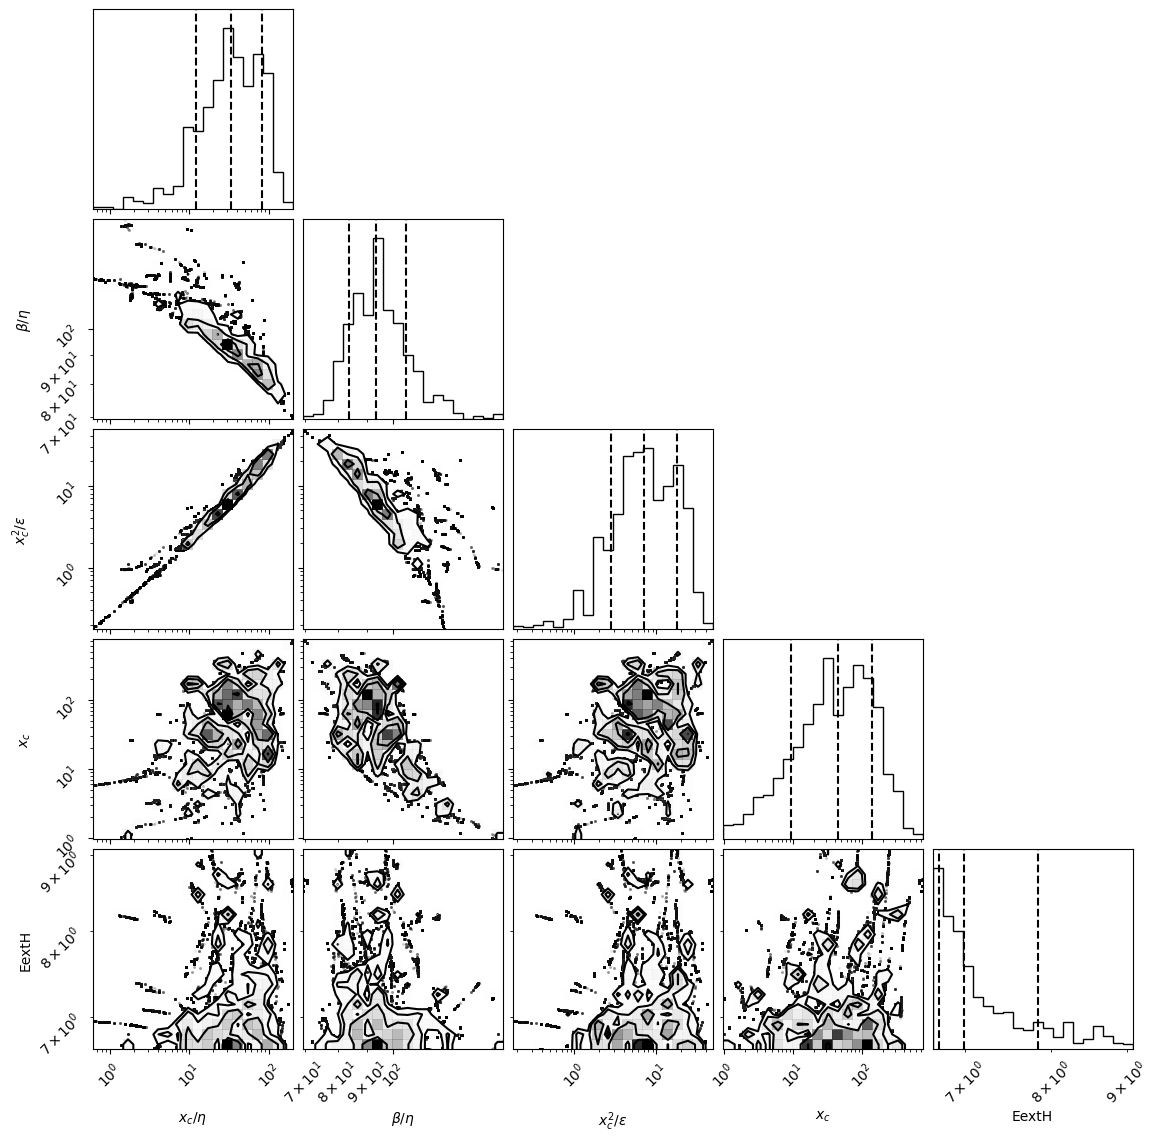

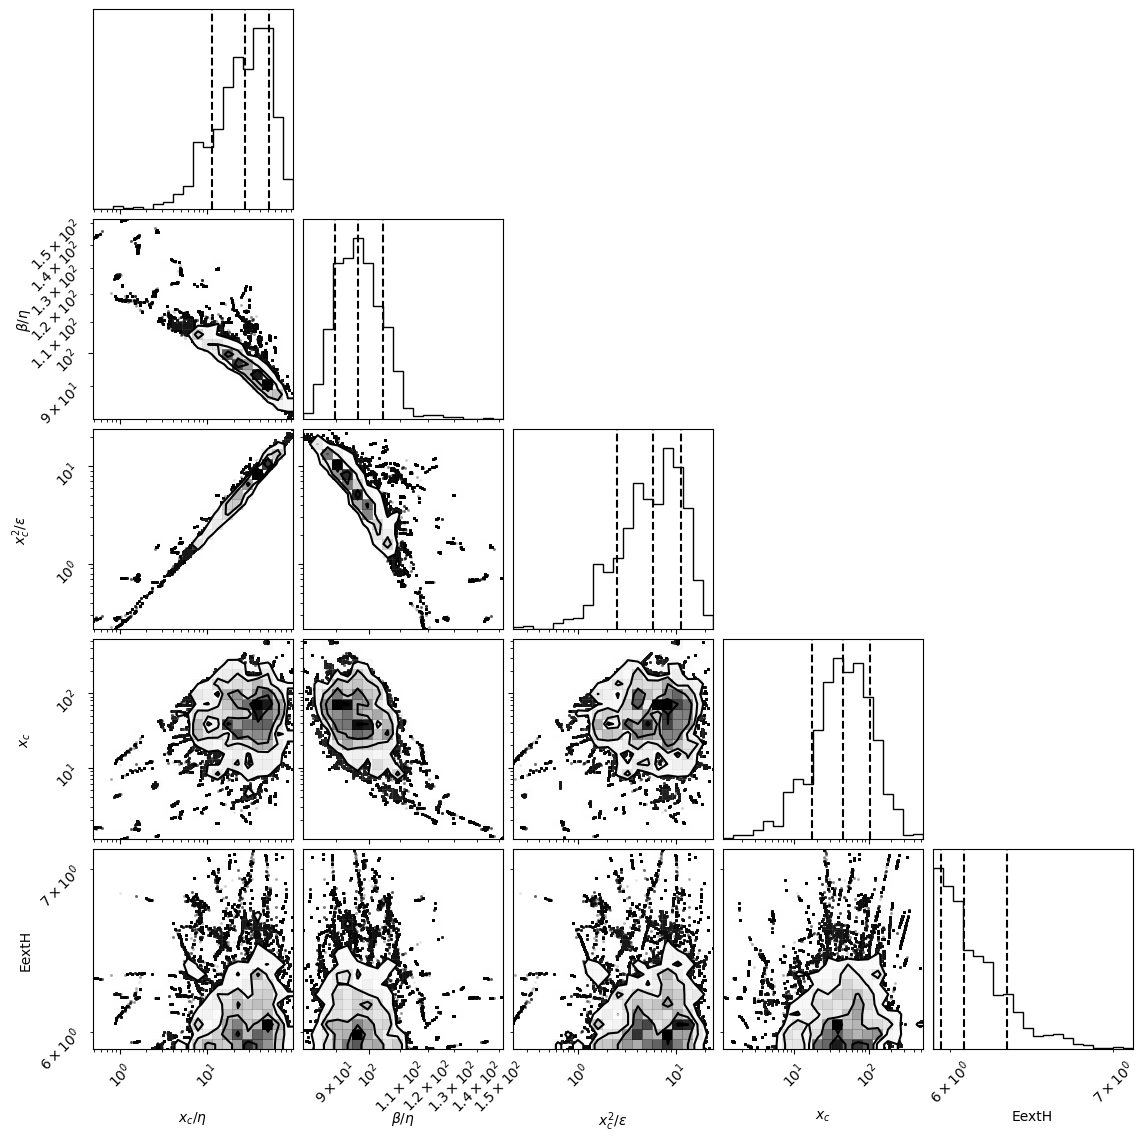

In [8]:
nruns = len(samples_trans.keys())
# fig, ax = plt.subplots(nruns,1, figsize=(10,10*nruns))
for key in samples_trans.keys():
    corner.corner(samples_trans[key], labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","EextH"], axes_scale='log',quantiles=[0.16, 0.5, 0.84])

In [9]:
if True:
    from SRtools import samples_utils as ssu
    from SRtools import config_lib as ccl
    config_dict = None
    path1 = "HUMANS/humans_M_combined.csv"
    post_path = os.path.join('posterior_csvs',path1.replace('.csv','_post.csv'))

    help_text ="run from baysian01, from joint posterior"

    post2 = ssu.JointPosterior(list(samples_trans.values()), list(lnprobs.values()), 100, log=True,config_params=config_dict,help_text=help_text,prior=None)
    post2.save_to_file(post_path)


Processing unique samples for set 2: 100%|██████████| 8608/8608 [00:00<00:00, 526843.26it/s]


In [10]:
import samples_utils as su
post = su.JointPosterior(list(samples_trans.values()), list(lnprobs.values()), bins = 100, log=True)

Processing unique samples for set 2: 100%|██████████| 8608/8608 [00:00<00:00, 511193.42it/s]


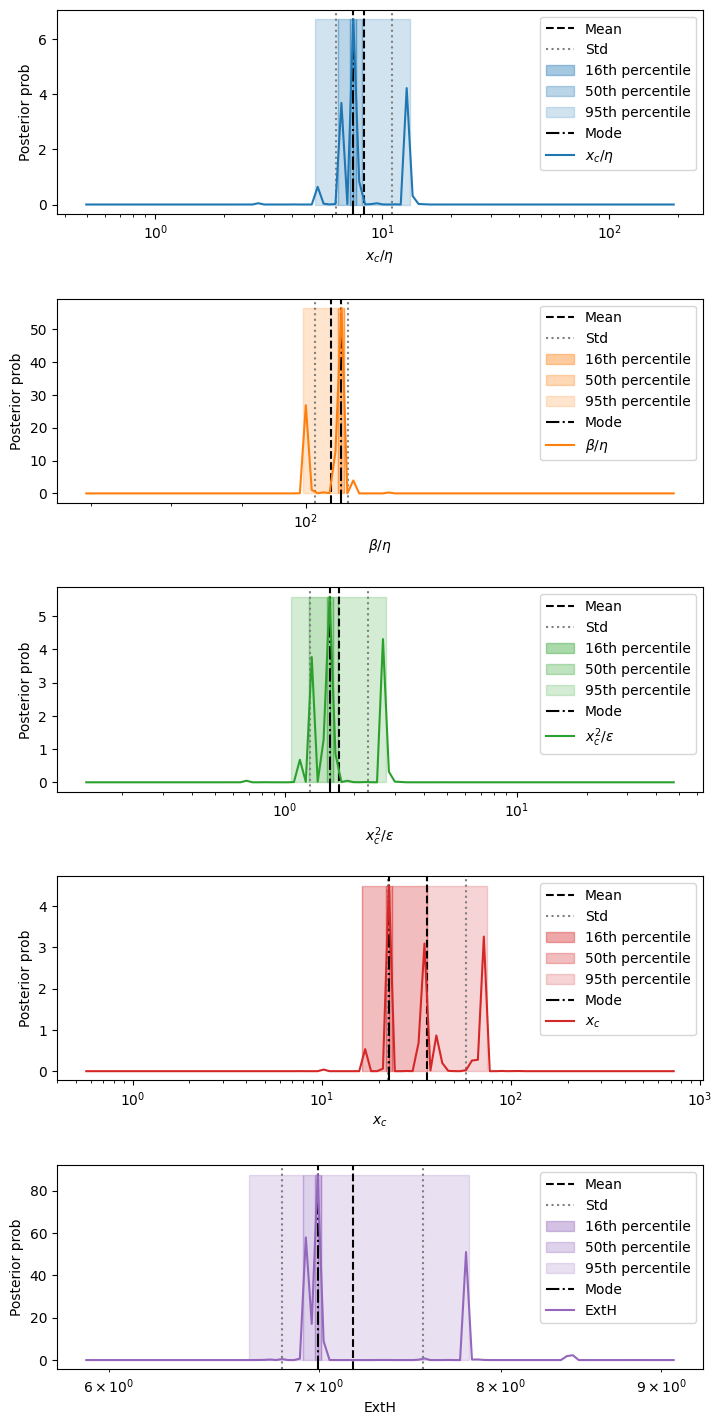

In [11]:
post.plot_1d_posteriors(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","ExtH"],scale='log')

In [12]:
path_days = f"{results_path.split('.csv')[0]}_days.csv" if results_path is not None else None
df=post.create_posterior_df(filepath=results_path, ds = [ds], ds_labels=['data'])
df_days=post.create_posterior_df(filepath=path_days, ds = [ds], ds_labels=['data'],rescale=scale)

Processing unique samples for set 2: 100%|██████████| 8405/8405 [00:00<00:00, 502811.57it/s]


Rescaling the samples TIME by 365


Processing unique samples for set 2: 100%|██████████| 8391/8391 [00:00<00:00, 502303.61it/s]


In [13]:
display(df)

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood
xc/eta,8.315,"[2.751, 2.067]",7.45,"[7.229, 7.677]","[6.806, 8.154]","[6.034, 14.018]",6.607
beta/eta,104.338,"[2.843, 2.767]",105.032,"[104.517, 105.55]","[103.494, 106.592]","[99.503, 106.592]",106.418
xc^2/epsilon,1.712,"[0.572, 0.429]",1.562,"[1.516, 1.608]","[1.516, 1.706]","[1.43, 2.897]",1.343
xc,36.064,"[22.03, 13.676]",37.622,"[36.287, 39.006]","[33.758, 41.928]","[20.358, 60.173]",35.589
ExtH,7.176,"[0.381, 0.362]",6.964,"[6.949, 6.979]","[6.949, 7.01]","[6.889, 7.04]",7.802
eta,3.811,"[1.156, 0.887]",4.965,"[4.794, 5.141]","[4.17, 5.513]","[3.154, 5.912]",5.387
beta,408.641,"[112.523, 88.229]",384.549,"[371.863, 397.668]","[347.733, 454.774]","[325.168, 636.037]",573.253
epsilon,524.819,"[426.539, 235.301]",1064.08,"[858.741, 1142.909]","[559.291, 1318.519]","[237.241, 1521.112]",942.903
sqrt(xc/eta),2.725,"[0.287, 0.26]",2.729,"[2.689, 2.771]","[2.609, 2.855]","[2.456, 3.525]",2.57
s= eta^0.5*xc^1.5/epsilon,0.569,"[0.0538, 0.0491]",0.571,"[0.563, 0.58]","[0.546, 0.597]","[0.515, 0.653]",0.523


In [44]:
display(df)

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood
xc/eta,7.632,1.723,7.374,"[6.389, 8.358]","[6.389, 10.328]","[4.42, 14.266]",6.607
beta/eta,106.203,2.004,105.514,"[104.941, 106.088]","[103.794, 106.088]","[100.353, 108.382]",106.418
xc^2/epsilon,1.51,0.401,1.837,"[1.594, 2.08]","[1.108, 2.08]","[0.136, 2.567]",1.343
xc,30.557,11.623,34.284,"[30.536, 38.033]","[23.039, 38.033]","[15.543, 60.523]",35.589
ExtH,7.024,0.266,6.965,"[6.949, 6.981]","[6.949, 7.013]","[6.885, 7.045]",7.802
eta,4.32,1.121,3.53,"[3.44, 3.62]","[3.26, 3.98]","[3.079, 5.782]",5.387
beta,463.279,121.989,580.554,"[571.92, 606.454]","[537.387, 623.72]","[330.188, 623.72]",573.253
epsilon,685.398,495.363,201.713,"[0.0253, 403.4]","[0.0253, 806.775]","[0.0253, 1210.15]",942.903
sqrt(xc/eta),2.813,0.319,2.898,"[2.832, 2.965]","[2.698, 3.099]","[2.431, 3.767]",2.57
s= eta^0.5*xc^1.5/epsilon,0.577,0.0546,0.603,"[0.586, 0.621]","[0.55, 0.657]","[0.479, 0.764]",0.523
